# Scraping the Partisan Divide: Sentiment, Text, & Network Analysis of an online political discussion forum.

### In this notebook I  apply data science techniques to investigate partisan division on scraped user post data from an online political discussion forum.

## My process:
 - Scrape text and user political ideology of each post in the forum in my given timeframe.
 - Consolidate partisanship into two groups along liberal to conservative political axis.
 - Distinguish top phrases for each group.
 - Analyze sentiment between partisan identities on posts matching political keywords.
 - Identify communities via network analysis to examine partisan division.


## Demonstrated Python Skills:
 - Web-scraping with Scrapy
 - Text Analysis with NLTK and Sklearn.CountVectorizer
 - Sentiment Analysis with TextBlob
 - Network Analysis with NetworkX and Community
 - Visualization with Seaborrn


# 1) Scraping Data with a Scrapy Spyder

##  See my github gist for the code of my spyder:

https://gist.github.com/fedickinson/322d2f801667666d219a774886552ccd


## Structure of Forum to Scrape:

### Defined Number of Threads -> Multiple Pages per Thread -> Multiple posts per page

## Process:

- load start page for for each thread

- load each page of each thread

- parse components of each post of each page in each thread


### Output: csv file 'forum.csv' with collected data

# 2) Import Scraped Data

In [1]:
#import packages

import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

In [2]:
forum = pd.read_csv("forum.csv")
forum.drop_duplicates(inplace=True)
forum.shape

(251125, 8)

# 3) Clean & Format Data

In [3]:
forum = forum.dropna(subset=['userName'], how='all')
forum.reset_index(drop=True,inplace=True)

In [4]:
#convert to numeric: threadReplies, userMoney, userPosts

#take commas out of strings
forum['threadReplies'] = forum['threadReplies'].str.replace(',', '')
forum['userMoney'] = forum['userMoney'].str.replace(',', '')
forum['userPosts'] = forum['userPosts'].str.replace(',', '')

#convert to numeric
forum['threadReplies'] = forum['threadReplies'].replace(' replies to this topic','', regex=True)
forum['threadReplies'] = pd.to_numeric(forum['threadReplies'])
forum['userMoney'] = pd.to_numeric(forum['userMoney'])
forum['userPosts'] = pd.to_numeric(forum['userPosts'])

In [5]:
# clean and convert dateTime data
forum['postDateTime'] = forum['postDateTime'].str.strip()
filter1 = forum['postDateTime'].str.contains("minutes ago")
filter2 = forum['postDateTime'].str.contains("Yesterday")
filter3 = forum['postDateTime'].str.contains("Today")
forum = forum[~filter1]
forum = forum[~filter2]
forum = forum[~filter3]

/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [6]:
forum['postDateTime'] = pd.to_datetime(forum['postDateTime'], format='%d %b %Y, %I:%M %p')
forum = forum[forum['postDateTime'] >= pd.datetime(2016, 1, 1)]

forum['YearMonth'] = forum['postDateTime'].map(lambda x: 1000*x.year + x.month)

In [7]:
#clean userPolitics field
forum['userPolitics'] = forum['userPolitics'].replace("<bound method SelectorList.extract of \[<Selector xpath='div\[3\]\/div\[2\]\/a\[2\]\/text\(\)' data='",'', regex=True)

forum['userPolitics'] = forum['userPolitics'].str.extract(r"data=' (\w+)\\n")

#sLeftRight
forum['sLeftRight'] = ''

forum.loc[forum['userPolitics'].isin(['Conservative','Republican','Libertarian','Capitalist']), 'sLeftRight'] = 'Conservative'

forum.loc[forum['userPolitics'].isin(['Liberal','Progressive','Socialist','Democratic','Anarchist','Green']), 'sLeftRight'] = 'Liberal' 

forum.head()

/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


,postDateTime,postText,threadReplies,threadTitle,userMoney,userName,userPolitics,userPosts,YearMonth,sLeftRight
15,2016-01-02 18:24:00,\n\n \n ...,5.0,Do you think Trump will ever mention the horri...,325.98,xxxxxxx,Revolutionary,16928,2016001,
16,2016-01-02 18:49:00,\n\n \n ...,5.0,Do you think Trump will ever mention the horri...,7036.96,TotallyRad,Liberal,9903,2016001,Liberal
17,2016-01-02 19:48:00,\n\n \n ...,5.0,Do you think Trump will ever mention the horri...,325.98,xxxxxxx,Revolutionary,16928,2016001,
18,2016-01-02 20:29:00,\n\n \n ...,5.0,Do you think Trump will ever mention the horri...,7036.96,TotallyRad,Liberal,9903,2016001,Liberal
19,2016-01-02 22:23:00,\n\n \n ...,5.0,Do you think Trump will ever mention the horri...,325.98,xxxxxxx,Revolutionary,16928,2016001,


In [8]:
#clean post text data
forum['postText'] = forum['postText'].str.strip()
forum['postText'] = forum['postText'].replace('\n','', regex=True)
forum['postText'] = forum['postText'].replace('^,','', regex=True)
forum['postText'] = forum['postText'].str.strip()
forum['postText'] = forum['postText'].replace('^,','', regex=True)
forum['postText'] = forum['postText'].replace('^\s+','', regex=True)

In [9]:
forum['postText'] = forum['postText'].str.replace(r"[\.\,\?\!\<\>\=\+\-\{\}\[\]\"\']",'')
forum['threadTitle'] = forum['threadTitle'].str.replace(r"[\.\,\?\!\<\>\=\+\-\{\}\[\]\"\']",'')

# 4) Apply NLP with NLTK

In [10]:
from nltk.corpus import stopwords

#apply stopwords

stop = set(stopwords.words('english'))

forum["postText_split"] = forum["postText"].str.lower().str.split()

forum['postText_split'] = forum['postText_split'].apply(lambda x: [item for item in x if item not in stop])


In [11]:
#reset index due to error at index 1469
forum.reset_index(inplace=True)

In [12]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemify(text):
    s= [stemmer.stem(i) for i in text]
    return s

#stem text

forum['postText_stemmed'] = [stemify(forum['postText_split'][i]) for i in range(0,len(forum['postText_split']))]


In [13]:
def joinify(i):
    s= [' '.join(i)]
    return s

#join text

forum['postText_joined'] = [joinify(forum['postText_stemmed'][i]) for i in range(0,len(forum['postText_stemmed']))]

#https://stackoverflow.com/questions/38147447/how-to-remove-square-bracket-from-pandas-dataframe
forum['postText_value'] = forum['postText_joined'].str[0]


# 4)  Apply Setiment Score with TextBlob

In [14]:
from textblob import TextBlob

In [15]:
forum['postText_sentiment'] = forum['postText_value'].apply(lambda post: TextBlob(post).sentiment)


In [16]:
forum[['postText_polarity', 'postText_subjectivity']] = forum['postText_sentiment'].apply(pd.Series)

In [17]:
forum['postText_tb'] = forum['postText'].apply(lambda row: TextBlob(row))

# 5) Exploratory Data Analysis

 ## Distribution of # of Posts / Thread

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1abcbe4dd8>]],
      dtype=object)

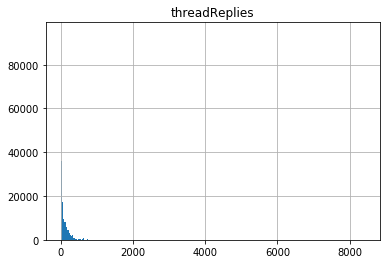

In [18]:
#plot distribution of # of threadReplies 
forum.hist(column="threadReplies",bins =500)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1abc9e8a58>]],
      dtype=object)

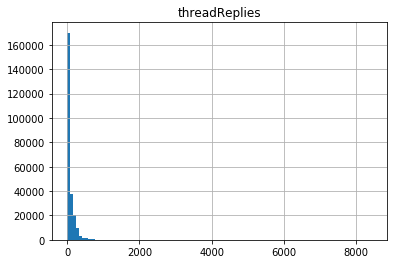

In [19]:
#we data is very right skewed... let's replot with the most replied to threads removed
forum_threads_max_replies_no_outliers = forum.iloc[500:]
forum_threads_max_replies_no_outliers.hist(column="threadReplies",bins = 100)

## When were there the most posts?

In [20]:
#posts over time `
forum['postDate'] = forum['postDateTime'].dt.date

In [21]:
#What dates had the most posts?

posts_over_time = forum[['postDate','postText']].groupby(['postDate']).agg(['count'])

posts_over_time.add_suffix('_Count').reset_index()

posts_over_time.columns = ["".join(x) for x in posts_over_time.columns.ravel()]
posts_over_time = posts_over_time.reset_index()
posts_over_time.sort_values(by=['postTextcount'],axis=0,ascending=False).head(n=10)

,postDate,postTextcount
593,2017-08-16,800
695,2017-12-01,782
709,2017-12-15,779
717,2017-12-23,743
589,2017-08-12,740
697,2017-12-03,726
640,2017-10-02,726
592,2017-08-15,708
733,2018-01-08,688
696,2017-12-02,680


##### What was happening in the news on the dates that had the most posts? 


- 2017-08-16
    - after Charlottesville riot (August 11, 2017)


- 2017-12-01
    - General Flynn indicted


- 2017-12-15	
    - GOP loses Alabama special elecion
    
    
- 2017-12-23
    - right after GOP passed tax bill
    

- 2017-08-12
    -  day  after Charlottesville riot (August 11, 2017)


##### Interesting two days coming from same week... might make sense to look at posts in larger intervals such as week.

##### Also would be interesting to follow an event from the start over time to see how threads develop regarding a specific topic... look at Charlottesville riot.


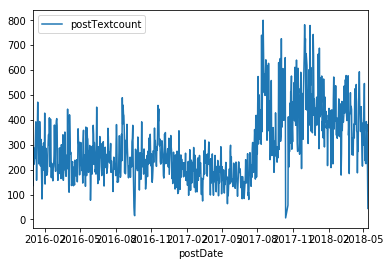

In [22]:
posts_over_time.plot(x='postDate',y='postTextcount',kind="line")

##  Analyzing Users

In [23]:
#Users dataframe
users_df = forum[['userName','userMoney','userPolitics','userPosts','postText_polarity','postText_subjectivity','sLeftRight']].drop_duplicates()


#get mean sentiment values for eahc user
users_df_g = users_df[['userName','postText_polarity','postText_subjectivity']].groupby(['userName']).mean()
users_df_g.reset_index(inplace=True)
users_df_g.head()


#get most recent post values for each user
users_df_sorted = users_df[['userName','userMoney','userPolitics','userPosts','sLeftRight']].sort_values(by='userPosts',ascending=False)
users_df_sorted.drop_duplicates('userName', keep='first',inplace=True)
users_df_sorted.reset_index(inplace=True,drop=True)
users_df_sorted.head()

#merge to get user dataframe with latest Uservalues for each User combined with their average sentiment score
user_df_sentiment = pd.merge(users_df_sorted,users_df_g,on="userName")

#to show numPosts, we want to remove the few outliers who have posted an extraordinary number of times
user_df_sentiment_outliers_removed = user_df_sentiment.iloc[18:]
user_df_sentiment_outliers_removed.head()



user_df_sentiment.head()

,userName,userMoney,userPolitics,userPosts,sLeftRight,postText_polarity,postText_subjectivity
0,Cannonpointer,NaN,NaN,75024,,-0.002348,0.497610
1,golfboy,48014.29,Conservative,51295,Conservative,-0.021701,0.522087
2,Huey,12317.42,Liberacon,40696,,-0.001258,0.489628
3,Str8tEdge,41657.45,Libertarian,34823,Conservative,-0.051177,0.523102
4,roadkill,11798.70,Conservative,33656,Conservative,0.058102,0.481287


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1abb9270b8>]],
      dtype=object)

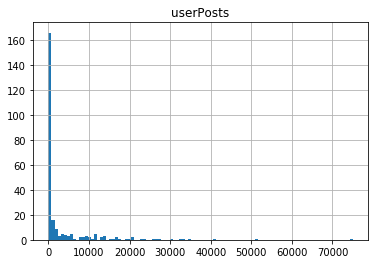

In [24]:
# histogram of # of posts / user

user_df_sentiment.hist(column="userPosts", bins = 100)

In [25]:
# standard metrics
userPosts_series = user_df_sentiment['userPosts'].values
userPosts_series = userPosts_series[~np.isnan(userPosts_series)]

print('mean = ' + str(np.nanmean(userPosts_series)))
print('std = ' + str(np.nanstd(userPosts_series)))

print('median = ' + str(np.nanmedian(userPosts_series)))
print('iqr = ' + str(sp.stats.iqr(userPosts_series)))

mean = 3727.8260869565215
std = 8872.24047269501
median = 49.0
iqr = 2141.0


In [26]:
# Barplot of identified partisanship of each user
user_barplot_df = user_df_sentiment.groupby('userPolitics').agg({'userPolitics' : 'count'})
user_barplot_df.columns = ['count']
user_barplot_df.reset_index(inplace=True)


In [27]:
user_barplot_df.sort_values(by='count',ascending=False,inplace=True)

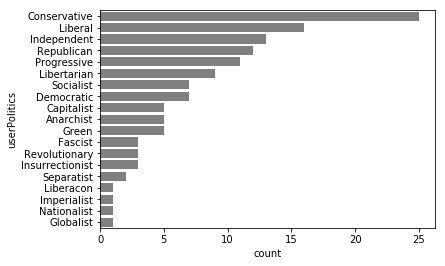

In [28]:
sns.barplot(x="count", y='userPolitics', data=user_barplot_df,color='grey')

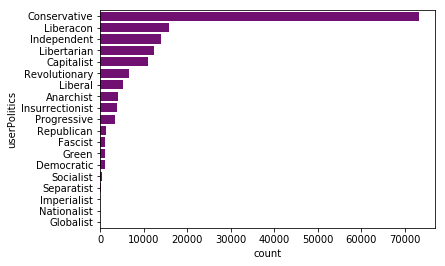

In [29]:
post_barplot_df = forum.groupby('userPolitics').agg({'userPolitics' : 'count'})
post_barplot_df.columns = ['count']
post_barplot_df.reset_index(inplace=True)
post_barplot_df.sort_values(by='count',ascending=False,inplace=True)
sns.barplot(x="count", y='userPolitics', data=post_barplot_df,color='purple')

In [30]:
print('The % of Posts with userPolitics filled in is: ' + str((forum['userPolitics'].count()/forum['postText'].count())))

The % of Posts with userPolitics filled in is: 0.6212757608639073


In [31]:
userPolitics_unique = user_df_sentiment[["userPolitics","sLeftRight"]].drop_duplicates()
clrs = ['red' if (x == 'Conservative') else 'blue' for x in userPolitics_unique["sLeftRight"] ]
userPolitics_unique.head()

,userPolitics,sLeftRight
0,NaN,
1,Conservative,Conservative
2,Liberacon,
3,Libertarian,Conservative
5,Liberal,Liberal


In [32]:
usersLeftRight = user_df_sentiment[user_df_sentiment['sLeftRight'] != ""]
forumLeftRight = forum[forum['sLeftRight'] != ""]

Text(0,0.5,'# of Users')

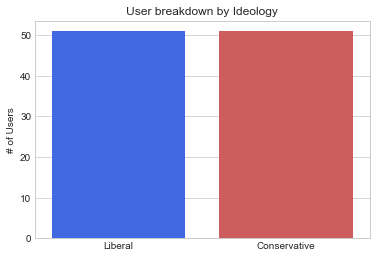

In [33]:
sns.set_style('whitegrid')
sns.countplot(x = usersLeftRight["sLeftRight"], palette = ['royalblue','indianred'], order=['Liberal','Conservative'], saturation=1)
plt.title('User breakdown by Ideology')
plt.xlabel('')
plt.ylabel('# of Users')

Text(0,0.5,'# of Posts')

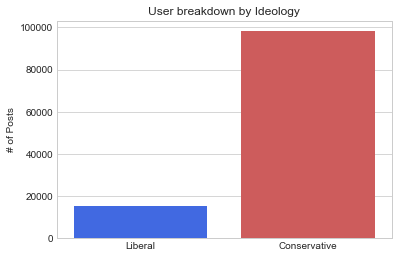

In [34]:
sns.set_style('whitegrid')
sns.countplot(x = forumLeftRight["sLeftRight"], palette =['royalblue','indianred'] , order=['Liberal','Conservative'], saturation=1)
plt.title('User breakdown by Ideology')
plt.xlabel('')
plt.ylabel('# of Posts')

# 6) Apply Sentiment Analysis to Political Keywords

### Trump

In [38]:
list_post_trump = []
list_post_trump.append(forum['postText_tb'].apply(lambda row: row.word_counts['trump']))
forum['postText_trump'] = list_post_trump[0]


forum_pt_trump = forum[(forum['postText_trump'] > 0)]
print(forum_pt_trump.shape[0])
#Users dataframe
users_df_pt_trump = forum_pt_trump[['userName','userMoney','userPolitics','userPosts','postText_polarity','postText_subjectivity','sLeftRight']].drop_duplicates()


#get mean sentiment values for each user
users_df_pt_trump_g = users_df_pt_trump[['userName','postText_polarity','postText_subjectivity']].groupby(['userName']).mean()
users_df_pt_trump_g.reset_index(inplace=True)


#get most recent post values for each user
users_df_pt_trump_sorted = users_df_pt_trump[['userName','userMoney','userPolitics','userPosts','sLeftRight']].sort_values(by='userPosts',ascending=False)
users_df_pt_trump_sorted.drop_duplicates('userName', keep='first',inplace=True)
users_df_pt_trump_sorted.reset_index(inplace=True,drop=True)
users_df_pt_trump_sorted.head()

#merge to get user dataframe with latest Uservalues for each User combined with their average sentiment score
user_df_pt_trump_sentiment = pd.merge(users_df_pt_trump_g,users_df_pt_trump_sorted,on="userName")

usersLeftRight_pt_trump = user_df_pt_trump_sentiment[user_df_pt_trump_sentiment['sLeftRight'] != ""]
forumLeftRight_pt_trump = forum_pt_trump[forum_pt_trump['sLeftRight'] != ""]

13731


([<matplotlib.axis.YTick at 0x1b67788f28>,
 <a list of 6 Text yticklabel objects>)

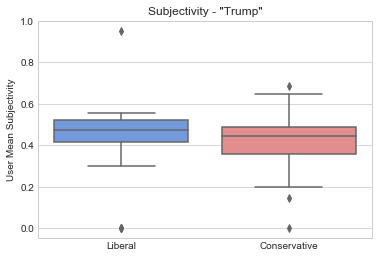

In [39]:
# subjectivity - trump
sns.set_style('whitegrid')
s_leftright_pt_trump_subjectiivity = sns.boxplot(x = usersLeftRight_pt_trump["sLeftRight"], y= usersLeftRight_pt_trump["postText_subjectivity"], palette = ['cornflowerblue','lightcoral'])
s_leftright_pt_trump_subjectiivity.set(title= 'Subjectivity - "Trump"', xticklabels=['Liberal','Conservative'], xlabel = '',ylabel='User Mean Subjectivity')
plt.yticks([0,.2,.4,.6,.8,1])


([<matplotlib.axis.YTick at 0x1b6893e0b8>,
 <a list of 7 Text yticklabel objects>)

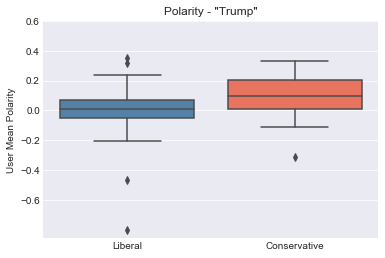

In [40]:
# polarity - trump
sns.set_style('darkgrid')
s_leftright_polarity_pt_trump = sns.boxplot(x = usersLeftRight_pt_trump["sLeftRight"], y= usersLeftRight_pt_trump["postText_polarity"], palette = ['steelblue','tomato'])
s_leftright_polarity_pt_trump.set(title= 'Polarity - "Trump"', xticklabels=['Liberal','Conservative'], xlabel = '',ylabel='User Mean Polarity')
plt.yticks([-.6,-.4,-.2,0,.2,.4,.6])

### Hilary / Clinton

In [41]:
list_post_clinton = []
list_post_clinton.append(forum['postText_tb'].apply(lambda row: row.word_counts['clinton']))
forum['postText_clinton'] = list_post_clinton[0]

list_post_hilary = []
list_post_hilary.append(forum['postText_tb'].apply(lambda row: row.word_counts['hilary']))
forum['postText_hilary'] = list_post_hilary[0]

forum_pt_hilary = forum[(forum['postText_hilary'] > 0) | (forum['postText_clinton'] > 0)]
print(forum_pt_hilary.shape[0])
#Users dataframe
users_df_pt_hilary = forum_pt_hilary[['userName','userMoney','userPolitics','userPosts','postText_polarity','postText_subjectivity','sLeftRight']].drop_duplicates()


#get mean sentiment values for eahc user
users_df_pt_hilary_g = users_df_pt_hilary[['userName','postText_polarity','postText_subjectivity']].groupby(['userName']).mean()
users_df_pt_hilary_g.reset_index(inplace=True)
users_df_pt_hilary_g.head()


#get most recent post values for each user
users_df_pt_hilary_sorted = users_df_pt_hilary[['userName','userMoney','userPolitics','userPosts','sLeftRight']].sort_values(by='userPosts',ascending=False)
users_df_pt_hilary_sorted.drop_duplicates('userName', keep='first',inplace=True)
users_df_pt_hilary_sorted.reset_index(inplace=True,drop=True)
users_df_pt_hilary_sorted.head()

#merge to get user dataframe with latest Uservalues for each User combined with their average sentiment score
user_df_pt_hilary_sentiment = pd.merge(users_df_pt_hilary_g,users_df_pt_hilary_sorted,on="userName")


usersLeftRight_pt_hilary = user_df_pt_hilary_sentiment[user_df_pt_hilary_sentiment['sLeftRight'] != ""]
forumLeftRight_pt_hilary = forum_pt_hilary[forum_pt_hilary['sLeftRight'] != ""]

3425


([<matplotlib.axis.YTick at 0x1b68a1b5f8>,
 <a list of 6 Text yticklabel objects>)

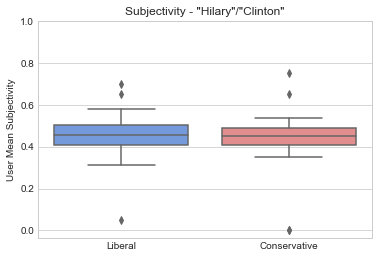

In [42]:
# subjectivity - hilary
sns.set_style('whitegrid')
s_leftright_pt_hilary_subjectiivity = sns.boxplot(x = usersLeftRight_pt_hilary["sLeftRight"], y= usersLeftRight_pt_hilary["postText_subjectivity"], palette = ['cornflowerblue','lightcoral'])
s_leftright_pt_hilary_subjectiivity.set(title= 'Subjectivity - "Hilary"/"Clinton"', xticklabels=['Liberal','Conservative'], xlabel = '',ylabel='User Mean Subjectivity')
plt.yticks([0,.2,.4,.6,.8,1])

([<matplotlib.axis.YTick at 0x1a3d74f6a0>,
 <a list of 7 Text yticklabel objects>)

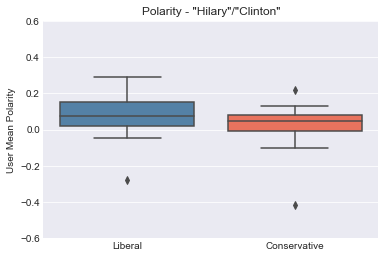

In [43]:
# polarity - hilary
sns.set_style('darkgrid')
s_leftright_polarity_pt_hilary = sns.boxplot(x = usersLeftRight_pt_hilary["sLeftRight"], y= usersLeftRight_pt_hilary["postText_polarity"], palette = ['steelblue','tomato'])
s_leftright_polarity_pt_hilary.set(title= 'Polarity - "Hilary"/"Clinton"', xticklabels=['Liberal','Conservative'], xlabel = '',ylabel='User Mean Polarity')
plt.yticks([-.6,-.4,-.2,0,.2,.4,.6])

### Obama

In [44]:
list_post_obama = []
list_post_obama.append(forum['postText_tb'].apply(lambda row: row.word_counts['obama']))
forum['postText_obama'] = list_post_obama[0]

forum_pt_obama = forum[(forum['postText_obama'] > 0)]
print(forum_pt_obama.shape[0])

#Users dataframe
users_df_pt_obama = forum_pt_obama[['userName','userMoney','userPolitics','userPosts','postText_polarity','postText_subjectivity','sLeftRight']].drop_duplicates()


#get mean sentiment values for eahc user
users_df_pt_obama_g = users_df_pt_obama[['userName','postText_polarity','postText_subjectivity']].groupby(['userName']).mean()
users_df_pt_obama_g.reset_index(inplace=True)
users_df_pt_obama_g.head()


#get most recent post values for each user
users_df_pt_obama_sorted = users_df_pt_obama[['userName','userMoney','userPolitics','userPosts','sLeftRight']].sort_values(by='userPosts',ascending=False)
users_df_pt_obama_sorted.drop_duplicates('userName', keep='first',inplace=True)
users_df_pt_obama_sorted.reset_index(inplace=True,drop=True)
users_df_pt_obama_sorted.head()

#merge to get user dataframe with latest Uservalues for each User combined with their average sentiment score
user_df_pt_obama_sentiment = pd.merge(users_df_pt_obama_g,users_df_pt_obama_sorted,on="userName")

usersLeftRight_pt_obama = user_df_pt_obama_sentiment[user_df_pt_obama_sentiment['sLeftRight'] != ""]
forumLeftRight_pt_obama = forum_pt_obama[forum_pt_obama['sLeftRight'] != ""]

6680


([<matplotlib.axis.YTick at 0x1b67a32e10>,
 <a list of 6 Text yticklabel objects>)

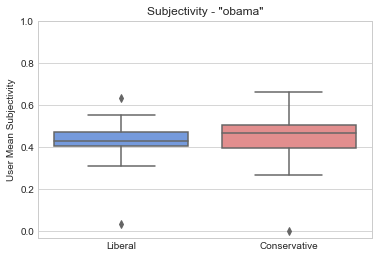

In [45]:
# subjectivity - obama
sns.set_style('whitegrid')
s_leftright_pt_obama_subjectiivity = sns.boxplot(x = usersLeftRight_pt_obama["sLeftRight"], y= usersLeftRight_pt_obama["postText_subjectivity"], palette = ['cornflowerblue','lightcoral'])
s_leftright_pt_obama_subjectiivity.set(title= 'Subjectivity - "obama"', xticklabels=['Liberal','Conservative'], xlabel = '',ylabel='User Mean Subjectivity')

plt.yticks([0,.2,.4,.6,.8,1])


([<matplotlib.axis.YTick at 0x1b42657278>,
 <a list of 7 Text yticklabel objects>)

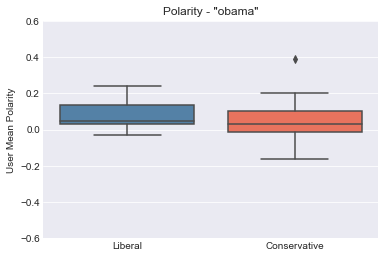

In [46]:
# polarity - obama
sns.set_style('darkgrid')
s_leftright_polarity_pt_obama = sns.boxplot(x = usersLeftRight_pt_obama["sLeftRight"], y= usersLeftRight_pt_obama["postText_polarity"], palette = ['steelblue','tomato'])
s_leftright_polarity_pt_obama.set(title= 'Polarity - "obama"', xticklabels=['Liberal','Conservative'], xlabel = '',ylabel='User Mean Polarity')
plt.yticks([-.6,-.4,-.2,0,.2,.4,.6])

### Russia

In [47]:
list_post_russia = []
list_post_russia.append(forum['postText_tb'].apply(lambda row: row.word_counts['russia']))
forum['postText_russia'] = list_post_russia[0]


forum_pt_russia = forum[(forum['postText_russia'] > 0)]
print(forum_pt_russia.shape[0])

#Users dataframe
users_df_pt_russia = forum_pt_russia[['userName','userMoney','userPolitics','userPosts','postText_polarity','postText_subjectivity','sLeftRight']].drop_duplicates()


#get mean sentiment values for eahc user
users_df_pt_russia_g = users_df_pt_russia[['userName','postText_polarity','postText_subjectivity']].groupby(['userName']).mean()
users_df_pt_russia_g.reset_index(inplace=True)
users_df_pt_russia_g.head()


#get most recent post values for each user
users_df_pt_russia_sorted = users_df_pt_russia[['userName','userMoney','userPolitics','userPosts','sLeftRight']].sort_values(by='userPosts',ascending=False)
users_df_pt_russia_sorted.drop_duplicates('userName', keep='first',inplace=True)
users_df_pt_russia_sorted.reset_index(inplace=True,drop=True)
users_df_pt_russia_sorted.head()

#merge to get user dataframe with latest Uservalues for each User combined with their average sentiment score
user_df_pt_russia_sentiment = pd.merge(users_df_pt_russia_g,users_df_pt_russia_sorted,on="userName")


usersLeftRight_pt_russia = user_df_pt_russia_sentiment[user_df_pt_russia_sentiment['sLeftRight'] != ""]
forumLeftRight_pt_russia = forum_pt_russia[forum_pt_russia['sLeftRight'] != ""]


1240


([<matplotlib.axis.YTick at 0x1b67b90a58>,
 <a list of 6 Text yticklabel objects>)

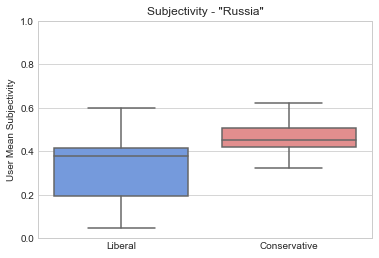

In [48]:
# subjectivity - russia
sns.set_style('whitegrid')
s_leftright_pt_russia_subjectiivity = sns.boxplot(x = usersLeftRight_pt_russia["sLeftRight"], y= usersLeftRight_pt_russia["postText_subjectivity"], palette = ['cornflowerblue','lightcoral'])
s_leftright_pt_russia_subjectiivity.set(title= 'Subjectivity - "Russia"', xticklabels=['Liberal','Conservative'], xlabel = '',ylabel='User Mean Subjectivity')
plt.yticks([0,.2,.4,.6,.8,1])


([<matplotlib.axis.YTick at 0x1b67f09be0>,
 <a list of 7 Text yticklabel objects>)

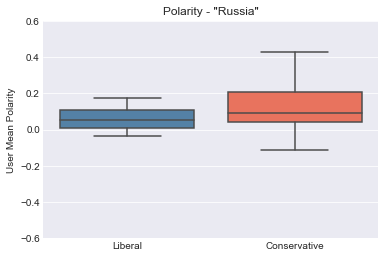

In [49]:
# polarity - russia
sns.set_style('darkgrid')
s_leftright_polarity_pt_russia = sns.boxplot(x = usersLeftRight_pt_russia["sLeftRight"], y= usersLeftRight_pt_russia["postText_polarity"], palette = ['steelblue','tomato'])
s_leftright_polarity_pt_russia.set(title= 'Polarity - "Russia"', xticklabels=['Liberal','Conservative'], xlabel = '',ylabel='User Mean Polarity')
plt.yticks([-.6,-.4,-.2,0,.2,.4,.6])

# 7) Top Words Analysis

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect_total = CountVectorizer(ngram_range=(2,2),min_df=500)


In [51]:
#Sort n_grams of two by count descending. 

corpus_total = forum['postText_value']

corpus_total_fit = count_vect_total.fit_transform(corpus_total)

total_counts = pd.DataFrame(corpus_total_fit.toarray(),columns=count_vect_total.get_feature_names()).sum()
ngram_total_df = pd.DataFrame(total_counts,columns=['count'])
print(ngram_total_df.shape)
ngram_total_df.sort_values(by=['count'],ascending=False)

(40, 1)


,count
look like,2280
dont know,1972
unit state,1564
donald trump,1431
dont think,1307
fake news,1111
hillari clinton,1104
white hous,979
dont want,977
im sure,953


In [52]:
count_vect = CountVectorizer(ngram_range=(2,5),min_df=20)

# Create separate df for Liberal and Conservative posts

topwords_liberal_df = forum[forum['sLeftRight'] =='Liberal']

topwords_conservative_df = forum[forum['sLeftRight'] == 'Conservative']


In [53]:
# apply for liberals
corpus_liberal = topwords_liberal_df['postText_value']

corpus_liberal_fit = count_vect.fit_transform(corpus_liberal)

liberal_counts = pd.DataFrame(corpus_liberal_fit.toarray(),columns=count_vect.get_feature_names()).sum()
ngram_liberal_df = pd.DataFrame(liberal_counts,columns=['count'])
print(ngram_liberal_df.shape)
ngram_liberal_df = ngram_liberal_df.sort_values(by=['count'],ascending=False)
ngram_liberal_df_20 = ngram_liberal_df.head(20)


(271, 1)


In [54]:
ngram_liberal_df_20.reset_index(inplace=True)
ngram_liberal_df_20.columns = ['Top 20 Phrases', 'count']

In [55]:
ngram_liberal_df_20

,Top 20 Phrases,count
0,donald trump,307
1,unit state,212
2,heh heh,199
3,dont know,195
4,hillari clinton,182
5,dont think,173
6,look like,165
7,new york,152
8,democrat parti,150
9,white hous,126


Text(0.5,1,'Top 20 Phrases - Liberals')

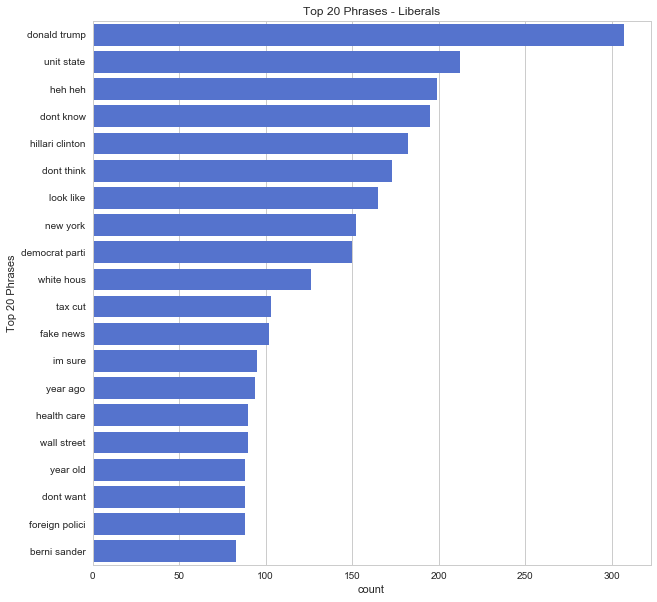

In [56]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x="count", y="Top 20 Phrases", data=ngram_liberal_df_20,palette=["royalblue"]).set_title('Top 20 Phrases - Liberals')

In [57]:
# apply for conservatives
corpus_conservative = topwords_conservative_df['postText_value']

corpus_conservative_fit = count_vect.fit_transform(corpus_conservative)

conservative_counts = pd.DataFrame(corpus_conservative_fit.toarray(),columns=count_vect.get_feature_names()).sum()
ngram_conservative_df = pd.DataFrame(conservative_counts,columns=['count'])
print(ngram_conservative_df.shape)
ngram_conservative_df = ngram_conservative_df.sort_values(by=['count'],ascending=False)
ngram_conservative_df_20 = ngram_conservative_df.head(20)
ngram_conservative_df_20
ngram_conservative_df_20.reset_index(inplace=True)

(3992, 1)


Text(0.5,1,'Top 20 Phrases - Conservatives')

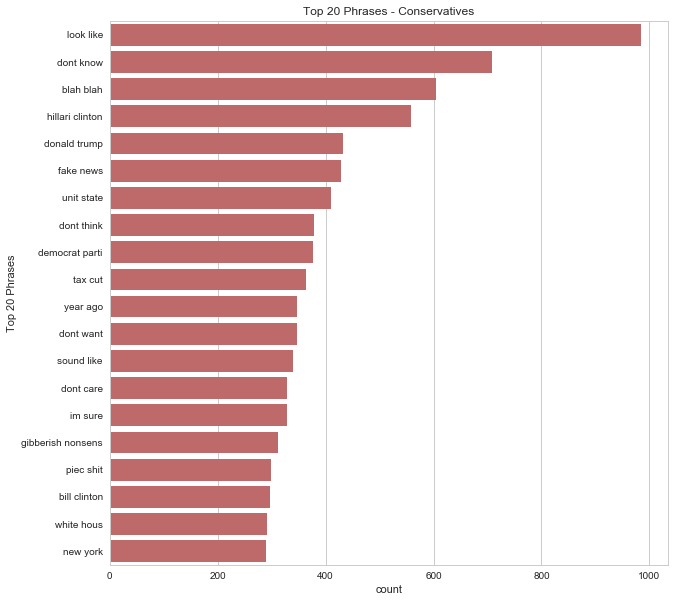

In [58]:

ngram_conservative_df_20.columns = ['Top 20 Phrases', 'count']
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10,10))
sns.barplot(x="count", y='Top 20 Phrases', data=ngram_conservative_df_20,palette=["indianred"]).set_title('Top 20 Phrases - Conservatives')

# 8) Social Network Analysis

##  Data Preparation

In [59]:
# get first postDateTime for each thread

firstpost_df = forum.groupby('threadTitle').agg({'postDateTime' : 'min'})
firstpost_df.reset_index(inplace=True)
print(firstpost_df.shape[0])
firstpost_df.head()

15795


,threadTitle,postDateTime
0,,2018-01-13 06:18:00
1,Birthright Citizenship,2017-06-07 23:19:00
2,Does Primary Voter Turnout Mean Anything,2016-02-24 11:37:00
3,‘Russian Troops’ Kept Hillary From Going to W...,2016-12-21 08:05:00
4,# 1 Halloween costume,2017-10-30 12:39:00


In [60]:
#merge userName and political view onto firstThreadPost df

forum_user_merge = forum[['threadTitle','postDateTime','userName','userPolitics','sLeftRight']]
forum_user_merge.drop_duplicates(inplace=True)
forum_firstpost_complete_df = firstpost_df.merge(forum_user_merge,how='left',on=['threadTitle','postDateTime'])


/Users/franklindickinson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [61]:
#rename columns to reflect threadOriginator and firstpost
forum_firstpost_complete_df.rename(columns={'postDateTime':'firstPostDateTime'}, inplace=True)
forum_firstpost_complete_df.rename(columns={'userName':'threadOriginator'}, inplace=True)
forum_firstpost_complete_df.rename(columns={'userPolitics':'originatorPolitics'}, inplace=True)
forum_firstpost_complete_df.rename(columns={'sLeftRight':'originatorLeftRight'}, inplace=True)


print(forum_firstpost_complete_df.shape[0])
forum_firstpost_complete_df.head()

16012


,threadTitle,firstPostDateTime,threadOriginator,originatorPolitics,originatorLeftRight
0,,2018-01-13 06:18:00,xxxxxxx,Revolutionary,
1,Birthright Citizenship,2017-06-07 23:19:00,Cannonpointer,NaN,
2,Does Primary Voter Turnout Mean Anything,2016-02-24 11:37:00,Fuelman,Capitalist,Conservative
3,‘Russian Troops’ Kept Hillary From Going to W...,2016-12-21 08:05:00,roadkill,Conservative,Conservative
4,# 1 Halloween costume,2017-10-30 12:39:00,Hypocrisy,Capitalist,Conservative


In [62]:
#insert new columns into main df

forum = forum.merge(forum_firstpost_complete_df,how='left',on='threadTitle')

In [63]:
# get aggregate for each user posting on thread by other user

forum_userMatrix = forum[['userName','threadOriginator','postText']].groupby(['userName','threadOriginator']).agg('count')
forum_userMatrix.sort_values(by=['postText'],ascending=False)
forum_userMatrix.reset_index(inplace=True)
#forum_userMatrix.head()

forum_userMatrix_2 = forum_userMatrix.drop(forum_userMatrix[forum_userMatrix['userName'] == forum_userMatrix['threadOriginator']].index)
forum_userMatrix_2.sort_values(by=['postText'],ascending=False,inplace=True)

forum_userMatrix_2.reset_index(inplace=True,drop=True)
print(forum_userMatrix_2.shape[0])
forum_userMatrix_2.head(n=20)

5241


,userName,threadOriginator,postText
0,roadkill,nefarious101,1523
1,Huey,Blackvegetable,1486
2,Huey,roadkill,1241
3,nuckin futz,roadkill,1194
4,roadkill,JoeyBone,1186
5,Cannonpointer,roadkill,1182
6,roadkill,Cannonpointer,1178
7,Bigsky,Cannonpointer,1174
8,Termin8tor,Blackvegetable,1150
9,roadkill,Blackvegetable,1148


In [64]:
#merge dataframes to get posts for all users

forum_userMatrix_3 = forum_userMatrix_2.merge(user_df_sentiment,how='left',on='userName')
forum_userMatrix_4 = forum_userMatrix_3.merge(user_df_sentiment,how='left',left_on='threadOriginator',right_on='userName',suffixes=['_pU','_tO'])


## Running Networks

In [65]:
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
print('NetworkX version: {}'.format(nx.__version__))

NetworkX version: 1.11


In [66]:
#https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.from_pandas_dataframe.html

G=nx.from_pandas_dataframe(forum_userMatrix_4, source= 'userName_pU', target= 'threadOriginator',edge_attr= ['postText','userPolitics_pU','sLeftRight_pU','userPolitics_tO','sLeftRight_tO'])

In [74]:
node_username_list = []
node_sLeftRight_list = []

for node in G:
    node_username_list.append(node)
    node_sLeftRight_list.append(user_df_sentiment.loc[user_df_sentiment['userName'] == node, 'sLeftRight'].iloc[0])
    
node_dict = dict(zip(node_username_list, node_sLeftRight_list))

colorlist = []
for value in node_sLeftRight_list:
    if value == 'Liberal':
            colorlist.append('blue')
    elif value == 'Conservative':
            colorlist.append('red')
    else:
            colorlist.append('grey')

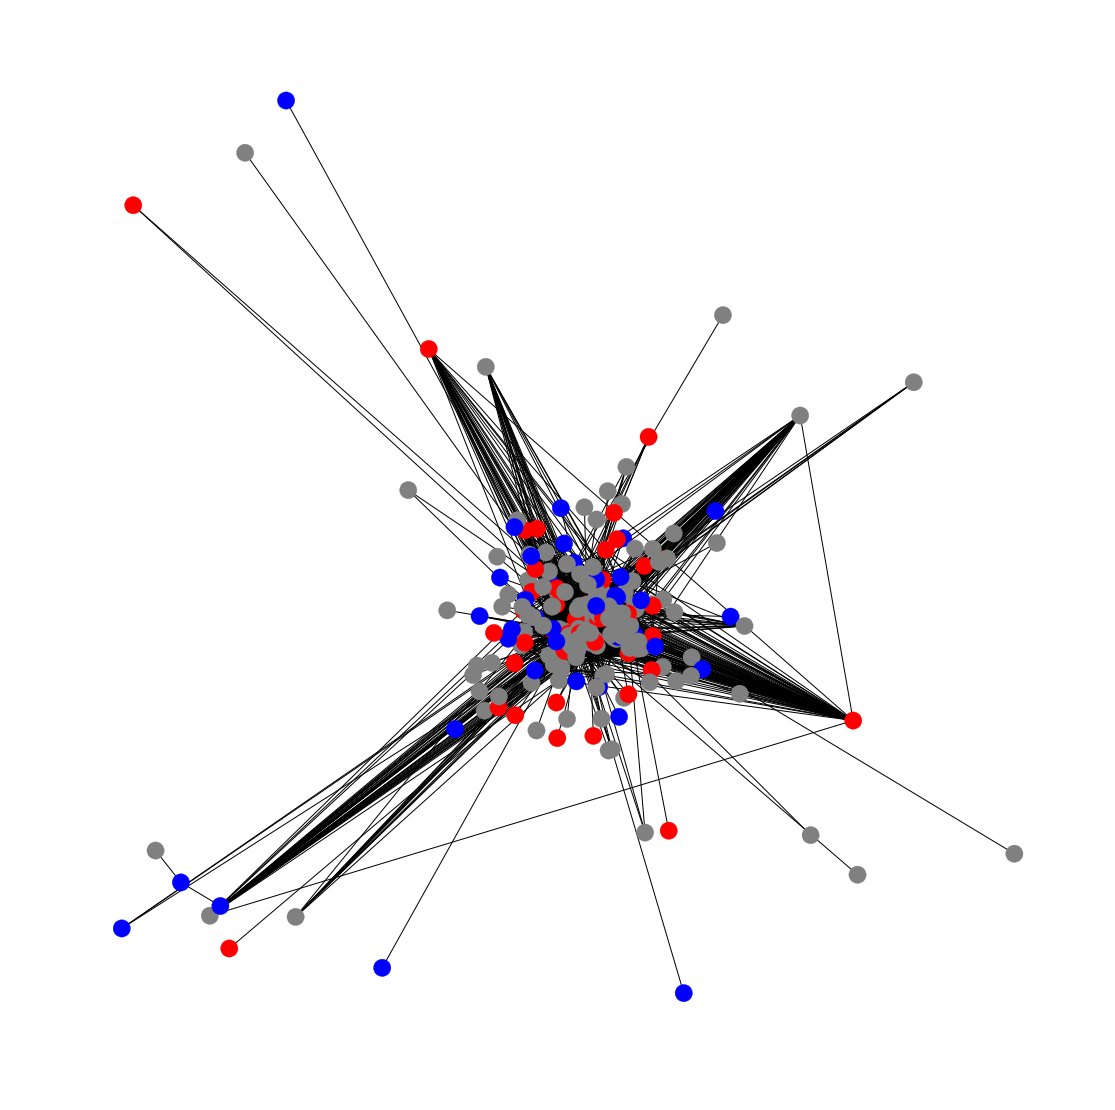

In [68]:
pos = nx.spring_layout(G, k=0.3*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(15, 15))
nx.draw(G, pos=pos, node_color = colorlist)
plt.show()


In [69]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 234
Number of edges: 3385
Average degree:  28.9316


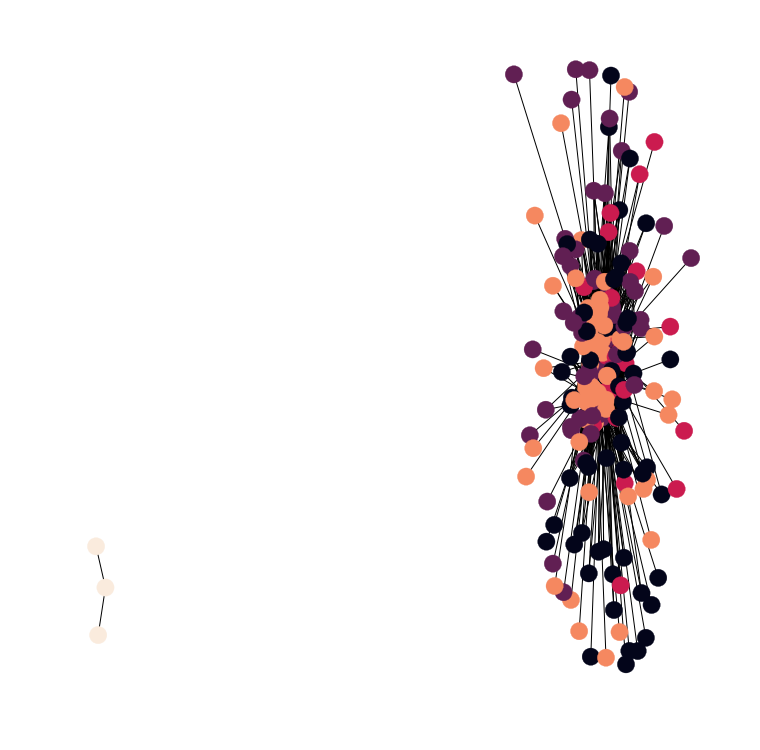

In [70]:
import community

parts_g = community.best_partition(G, weight="postText")
values_g = [parts_g.get(node) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.3*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos, node_color = values_g)
plt.show()

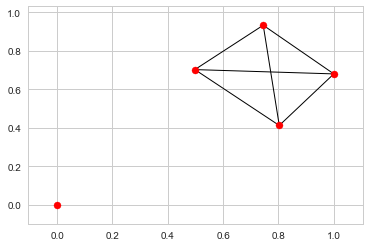

In [71]:
parts_i = community.induced_graph(parts_g,G,weight='postText')
nx.draw_networkx(parts_i, node_size = 50, with_labels = False)


In [72]:
bt = nx.betweenness_centrality(G)

In [78]:
listkey = []
listvalue = []

for k, v, in parts_g.items():
    listkey.append(k)
    listvalue.append(v)
    
community_df = pd.DataFrame(
 {'userName': listkey,'node_group': listvalue})

node_importance= sorted(bt.items(), key = lambda v: -v[1])
parallel_betweenness_centrality_df = pd.DataFrame(node_importance, columns=['userName','parallel_betweenness_centrality'])

parallel_betweenness_centrality_df.sort_values(by='parallel_betweenness_centrality',ascending=False,inplace=True)

parallel_betweenness_centrality_df['parallel_betweenness_centrality_rank'] = range(1, len(parallel_betweenness_centrality_df) + 1)

community_merged_df = community_df.merge(parallel_betweenness_centrality_df, how='left',on='userName')

# get aggregate counts for each node group
forum_userMatrix_5 = user_df_sentiment.merge(community_merged_df, how='left', on='userName')

forum_userMatrix_6 = forum_userMatrix_5[['node_group','userName','userPosts','sLeftRight','postText_polarity','postText_subjectivity','parallel_betweenness_centrality','parallel_betweenness_centrality_rank']].copy()
forum_userMatrix_6.drop_duplicates(inplace=True)

usernames_distinct = forum_userMatrix_6['userName'].drop_duplicates()

forum_userMatrix_6['LeftRight_binary'] = np.where(forum_userMatrix_6['sLeftRight']!= '', 1,0)

forum_userMatrix_6['conservative_binary'] = np.where(forum_userMatrix_6['sLeftRight']=='Conservative', 1,0)



# forum_userMatrix_6.groupby('node_group').agg({'userPosts' : ['sum','mean','std'],'userName' : 'count','LeftRight_binary' : 'sum','conservative_binary' : 'sum','postText_polarity' : ['mean','std'],'postText_subjectivity' : ['mean','std'], 'parallel_betweenness_centrality' : ['mean','std'], 'parallel_betweenness_centrality_rank' : ['mean','std']})
forum_userMatrix_6.groupby('node_group').agg({'userPosts' : ['sum','mean','std'],'userName' : 'count','LeftRight_binary' : 'sum','conservative_binary' : 'sum','postText_polarity' : ['mean','std'],'postText_subjectivity' : ['mean','std'], 'parallel_betweenness_centrality' : 'sum'})


userPosts                            userName LeftRight_binary  \
                 sum         mean           std    count              sum   
node_group                                                                  
0.0           230430  3245.492958   7814.731563       71               32   
1.0           266312  4365.770492  12653.131178       61               19   
2.0            89096  3563.840000   6651.951516       25               12   
3.0           357252  4827.729730   7882.223515       74               30   
4.0                7     2.333333      0.577350        3                2   

           conservative_binary postText_polarity            \
                           sum              mean       std   
node_group                                                   
0.0                         20          0.049938  0.155669   
1.0                          7          0.038596  0.111253   
2.0                          7          0.009426  0.127681   
3.0                         15          0.032100  0.193955   
4.0                          0          0.046591  0.046591   

           postText_subjectivity           parallel_betweenness_centrality  
                            mean       std                             sum  
node_group                                                                  
0.0                     0.388177  0.186992                        0.393454  
1.0                     0.362314  0.196508                        0.352871  
2.0                     0.410619  0.186935                        0.114770  
3.0                     0.445022  0.169413                        0.246090  
4.0                     0.221480  0.221480                        0.000037